# Summer 2022 Data Science Intern Challenge 

## Q1
On Shopify, we have exactly 100 sneaker shops, and each of these shops sells only one model of shoe. We want to do some analysis of the average order value (AOV). When we look at orders data over a 30 day window, we naively calculate an AOV of $3145.13. Given that we know these shops are selling sneakers, a relatively affordable item, something seems wrong with our analysis.

In [44]:
# import needed packages for dataset analysis
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [45]:
# import given dataset
df = pd.read_excel('2019 Winter Data Science Intern Challenge Data Set.xlsx')
df.head()

,order_id,shop_id,user_id,order_amount,total_items,payment_method,created_at
0,1.0,53.0,746.0,224.0,2.0,cash,2017-03-13 12:36:56.190
1,2.0,92.0,925.0,90.0,1.0,cash,2017-03-03 17:38:51.999
2,3.0,44.0,861.0,144.0,1.0,cash,2017-03-14 04:23:55.595
3,4.0,18.0,935.0,156.0,1.0,credit_card,2017-03-26 12:43:36.649
4,5.0,18.0,883.0,156.0,1.0,credit_card,2017-03-01 04:35:10.773


In [46]:
df.describe()

,order_id,shop_id,user_id,order_amount,total_items
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000
mean,2500.500000,50.078800,849.092400,3145.128000,8.78720
std,1443.520003,29.006118,87.798982,41282.539349,116.32032
min,1.000000,1.000000,607.000000,90.000000,1.00000
25%,1250.750000,24.000000,775.000000,163.000000,1.00000
50%,2500.500000,50.000000,849.000000,284.000000,2.00000
75%,3750.250000,75.000000,925.000000,390.000000,3.00000
max,5000.000000,100.000000,999.000000,704000.000000,2000.00000


### 1) Think about what could be going wrong with our calculation. Think about a better way to evaluate this data. 

Based on the description of the dataset, there is no null value in this dataset.

The "order_amount" and "total_items" categories have a skewed data distribution, each having a high maximum value of 704000 and 2000 respectively. 

The "order_amount" mean (AOV) has a value of 3145.128 and the standard deviation was calculated to be 41282.54, which shows that using the mean value alone would not be a useful metric as the higher mean is a result of the long tailed distribution.

We can use a quick boxplot visualization to look at the outliers and filter for these data points for further analysis.

<bound method Figure.show of <Figure size 432x288 with 2 Axes>>

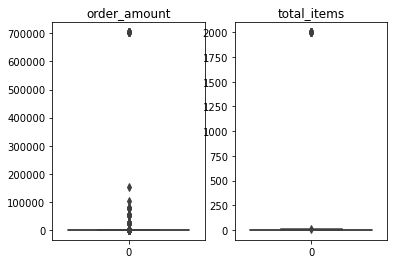

In [47]:
# Demonstrate data distribution through boxplot
fig, axes = plt.subplots(1, 2)
sns.boxplot(data=df['order_amount'], orient='v', ax= axes[0])
axes[0].set_title('order_amount')

sns.boxplot(data=df['total_items'], orient='v', ax= axes[1])
axes[1].set_title('total_items')

fig.show

We can see some obvious outliers from the boxplot visualization above, we can filter for these data points for further analysis by taking points above the upper bound.

In [49]:
# 1st quartile = 25% value
q1_order_amount = 163.000
q1_total_items = 1.000
 
# 3rd quartile b= 75%
q3_order_amount = 390.000
q3_total_items = 3.000

# find iqr region
iqr_order_amount = q3_order_amount - q1_order_amount
iqr_total_items = q3_total_items - q1_total_items
 
# find upper and lower bound
upper_order_amount = q3_order_amount + (1.5* iqr_order_amount)
lower_order_amount = q1_order_amount - (1.5* iqr_order_amount)

upper_total_items = q3_total_items + (1.5 * iqr_total_items)
lower_total_items = q1_total_items - (1.5 * iqr_total_items)

print(f'order_amount: iqr={iqr_order_amount}, upper bound={upper_order_amount}, lower bound={lower_order_amount}')
print(f'total_items: iqr={iqr_total_items}, upper bound={upper_total_items}, lower bound={lower_total_items}')

order_amount: iqr=227.0, upper bound=730.5, lower bound=-177.5
total_items: iqr=2.0, upper bound=6.0, lower bound=-2.0


After finding the upper bound of the interquantile range we can filter for values above it for the order_amount (730.5) and total_items (6.0) to get the outliers.

In [50]:
# order_amount outliers
order_amount_outlier = df[df['order_amount'] > 730.5]
print('number of order_amount outlier above upper bound =', order_amount_outlier ['order_amount'].count())

order_amount_outlier_count = order_amount_outlier['order_amount'].value_counts()
order_amount_outlier_count.sort_index(ascending=False).head(10)

number of order_amount outlier above upper bound = 141


704000.0    17
154350.0     1
102900.0     1
77175.0      9
51450.0     16
25725.0     19
1760.0       1
1408.0       2
1086.0       1
1064.0       1
Name: order_amount, dtype: int64

In [51]:
# total_items outliers
total_items_outlier = df[df['total_items'] > 6.0]
print('number of total_items outlier above upper bound =', total_items_outlier ['total_items'].count())

total_items_outlier_count = total_items_outlier['total_items'].value_counts()
total_items_outlier_count.sort_index(ascending=False).head()

number of total_items outlier above upper bound = 18


2000.0    17
8.0        1
Name: total_items, dtype: int64

There are an abnormally large number of orders with high order_amounts (e.g. 704000, 51450 and 25725) coming from multiple unique orders. This could either be from a reoccuring bulk order or potentially a scam. Similarly with total_items, majority of the outliers are for orders with 2000 items.

Taking a look at the orders with 2000 total_items.

In [52]:
total_items_outlier[total_items_outlier['total_items'] == 2000].sort_values('created_at')

,order_id,shop_id,user_id,order_amount,total_items,payment_method,created_at
520,521.0,42.0,607.0,704000.0,2000.0,credit_card,2017-03-02 04:00:00
4646,4647.0,42.0,607.0,704000.0,2000.0,credit_card,2017-03-02 04:00:00
60,61.0,42.0,607.0,704000.0,2000.0,credit_card,2017-03-04 04:00:00
15,16.0,42.0,607.0,704000.0,2000.0,credit_card,2017-03-07 04:00:00
2297,2298.0,42.0,607.0,704000.0,2000.0,credit_card,2017-03-07 04:00:00
1436,1437.0,42.0,607.0,704000.0,2000.0,credit_card,2017-03-11 04:00:00
2153,2154.0,42.0,607.0,704000.0,2000.0,credit_card,2017-03-12 04:00:00
1362,1363.0,42.0,607.0,704000.0,2000.0,credit_card,2017-03-15 04:00:00
1602,1603.0,42.0,607.0,704000.0,2000.0,credit_card,2017-03-17 04:00:00
1562,1563.0,42.0,607.0,704000.0,2000.0,credit_card,2017-03-19 04:00:00


All of the transactions with 2000 total_items are associated with one user and within a span of one month, with multiple duplicate purchases. The total transaction was almost 12 million, this is very suspicious and should be monitored for potential scam.

Finally taking a look at the average cost per shoe for these high transactions order amounts.

In [53]:
(order_amount_outlier['order_amount']/order_amount_outlier['total_items']).value_counts().nlargest(5)

25725.0    46
352.0      23
187.0       8
156.0       5
153.0       5
dtype: int64

We can see that there are 46 unique orders which all have items being sold for 25725, this is concerning and should be flagged since retails shoes are not normally sold at this price.

#### Conclusion:
Analyzing the outliers for order_amount and total_items revealed certain abnormal orders, some of which were selling at extremely high prices, or a single shop selling massive orders frequently to a single user. These are signs of potential fraudulent transactions and should warrant further investigation.

### 2) What metric would you report for this dataset?

Since the mean of the order_amount is highly effected by the skewness of the data, the median would be a better data evaluation metric since it relies on the middle value of an ordered sequence, which is more robust to outliers.

### 3) What is its value?

In [114]:
# find the median value of the order_amount
df['order_amount'].median()

284.0

Therefore the median value of order_amount is 284 which is more reasonable compared to the 3145.13 value originally calculated with the mean.

## Q2
For this question you’ll need to use SQL. Please use queries to answer the following questions. Paste your queries along with your final numerical answers below.

### 1) How many orders were shipped by Speedy Express in total?

#### SQL Query
SELECT count (*)

FROM Orders o

JOIN Shippers s 

  ON s.ShipperName = "Speedy Express" 

 AND o.ShipperID = s.ShipperID 

Answer: A total of **54** orders were shipped by Speedy Express.

### 2) What is the last name of the employee with the most orders?

#### SQL Query
SELECT e.LastName, count(o.OrderID)

FROM Orders o

JOIN Employees e ON e.EmployeeID = o.EmployeeID

GROUP BY e.EmployeeID

ORDER BY 2 DESC

LIMIT 1

Answer: The employee with the last name **Peacock** has the most orders with **40 total orders**.

### 3) What product was ordered the most by customers in Germany?

#### SQL Query

SELECT p.ProductName, SUM(od.Quantity)

FROM OrderDetails od

JOIN Products p ON od.ProductID = p.ProductID

JOIN Orders o on od.OrderID = o.OrderID

JOIN Customers c on c.CustomerID = o.CustomerID

WHERE c.Country = 'Germany'

GROUP BY p.ProductID

ORDER BY 2 DESC

LIMIT 1

Answer: The product that was ordered the most by customers in Germany is **Boston Crab Meat** with a total order amount of **160**